#**Importing Libraries**


In [ ]:
import pandas as pd
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

#**Data Collection & Pre-Processing**

In [ ]:
df1 = pd.read_csv("spam.csv" , encoding = "latin-1")

In [ ]:
df1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df1 = df1[['v1', 'v2']]
df1 = df1.rename(columns = {'v1': 'target', 'v2': 'text'})

In [ ]:
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
from sklearn import preprocessing

In [ ]:
#Encoding Spam to 1 and ham to 0
df1['target'] = df1['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
df1.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# missing values
df1.isnull().sum()

target    0
text      0
dtype: int64

In [ ]:
#Duplicate values
df1.duplicated().sum()

403

In [ ]:
# remove the duplicates
df1 = df1.drop_duplicates(keep = 'first')

In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.shape

(5169, 2)

## **EDA**

In [ ]:
df1.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df1['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

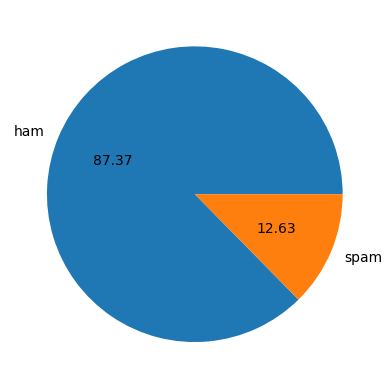

In [ ]:
import matplotlib.pyplot as plt
plt.pie(df1['target'].value_counts(), labels = ['ham', 'spam'], autopct = "%0.2f")
plt.show()

In [ ]:
# Data is imbalanced
# Adding extra dataset to make it somewhat balanced


In [ ]:
df2= pd.read_csv("smsdataset.csv" , encoding = "latin-1")

In [ ]:
df2.head()

,v1,v2
0,spam,U were outbid by simonwatson5120 on the Shinco...
1,ham,Do you still have the grinder?
2,ham,No. Yes please. Been swimming?
3,ham,No de.am seeing in online shop so that i asked.
4,ham,"Faith makes things possible,Hope makes things ..."


In [ ]:
df2.isnull().sum()

v1    0
v2    0
dtype: int64

In [ ]:
df2.duplicated().sum()

264

In [ ]:
df2= df2.drop_duplicates(keep = 'first')

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4193 entries, 0 to 4455
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      4193 non-null   object
 1   v2      4193 non-null   object
dtypes: object(2)
memory usage: 98.3+ KB


In [ ]:
df2 = df2.rename(columns = {'v1': 'target', 'v2': 'text'})

In [ ]:
df2['target'] = df2['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
df2['target'].value_counts()

0    3659
1     534
Name: target, dtype: int64

In [ ]:
spam_df = df2[df2['target'] == 1]

In [ ]:
spam_df.head()

,target,text
0,1,U were outbid by simonwatson5120 on the Shinco...
9,1,December only! Had your mobile 11mths+? You ar...
15,1,"UpgrdCentre Orange customer, you may now claim..."
19,1,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...
29,1,Double mins and txts 4 6months FREE Bluetooth ...


In [ ]:
df = pd.concat([df1, spam_df], ignore_index=True)


In [ ]:
df

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5698,1,"Do you ever notice that when you're driving, a..."
5699,1,"You have won ?1,000 cash or a ?2,000 prize! To..."
5700,1,IMPORTANT MESSAGE. This is a final contact att...
5701,1,FreeMsg Hi baby wow just got a new cam moby. W...


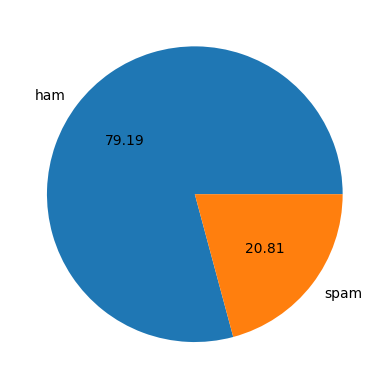

In [ ]:
plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'], autopct = "%0.2f")
plt.show()

In [ ]:
#IMPROVED SPAM PERCENTAGE 15 TO ALMOST 25
#REMAINING IMBALANCE WILL BE TAKEN CARE BY SMOTE

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df['num_characters'] = df['text'].apply(len)

In [ ]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
#number of words
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [ ]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [ ]:
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [ ]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5703.000000,5703.000000,5703.000000,5703.000000
mean,0.208136,84.590391,19.327196,2.062073
std,0.406010,58.885467,13.152916,1.484045
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,38.000000,9.000000,1.000000
50%,0.000000,67.000000,16.000000,2.000000
75%,0.000000,133.000000,28.000000,3.000000
max,1.000000,910.000000,220.000000,38.000000


In [ ]:
# ham messages
df[df['target'] == 0].describe()

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [ ]:
#spam messages
df[df['target'] == 1].describe()

,target,num_characters,num_words,num_sentences
count,1187.0,1187.000000,1187.000000,1187.000000
mean,1.0,138.352991,27.710194,2.982308
std,0.0,30.429709,7.051742,1.493276
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,158.000000,32.000000,4.000000
max,1.0,226.000000,46.000000,9.000000


If we look at the mean values than clearly we can see that mostly spam messages are longer in length

In [ ]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

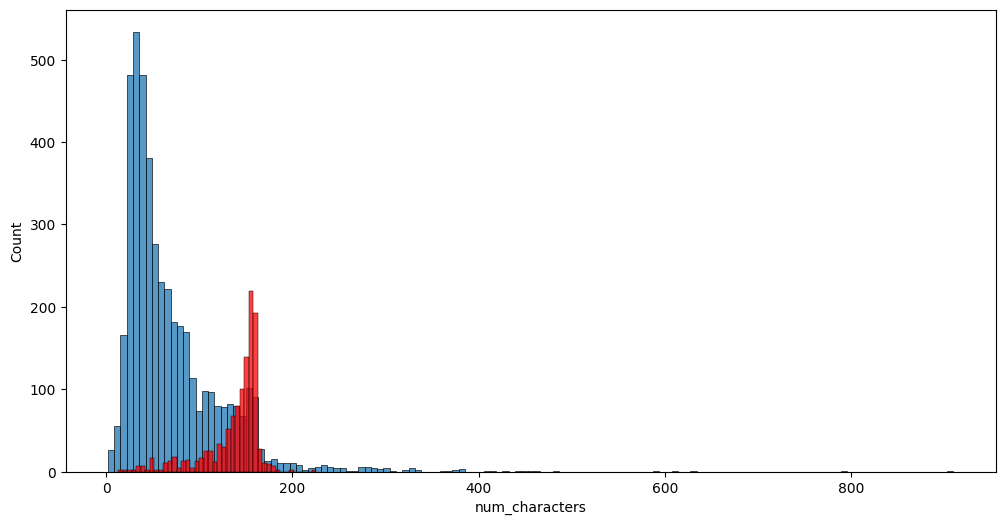

In [ ]:
plt.figure(figsize = (12, 6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color = 'red')

<Axes: xlabel='num_words', ylabel='Count'>

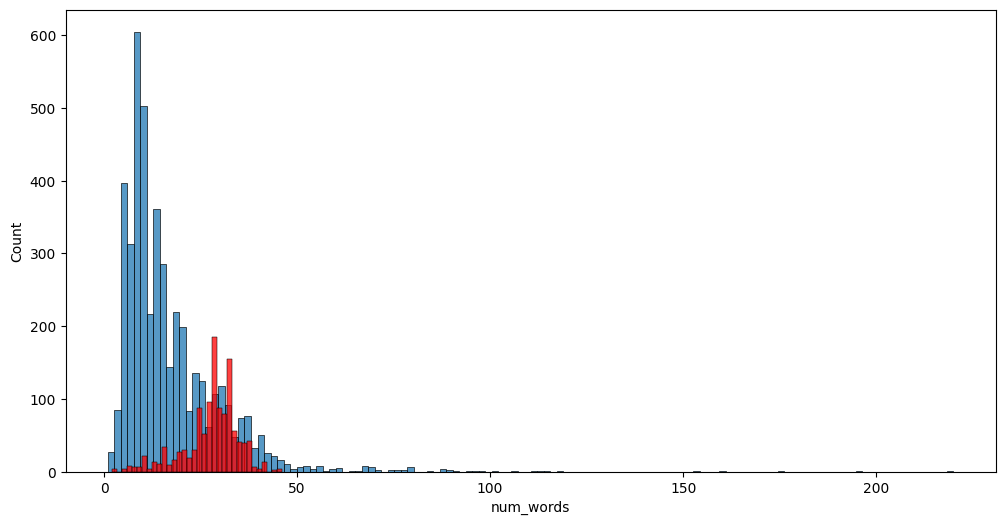

In [ ]:
plt.figure(figsize = (12, 6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color = 'red')

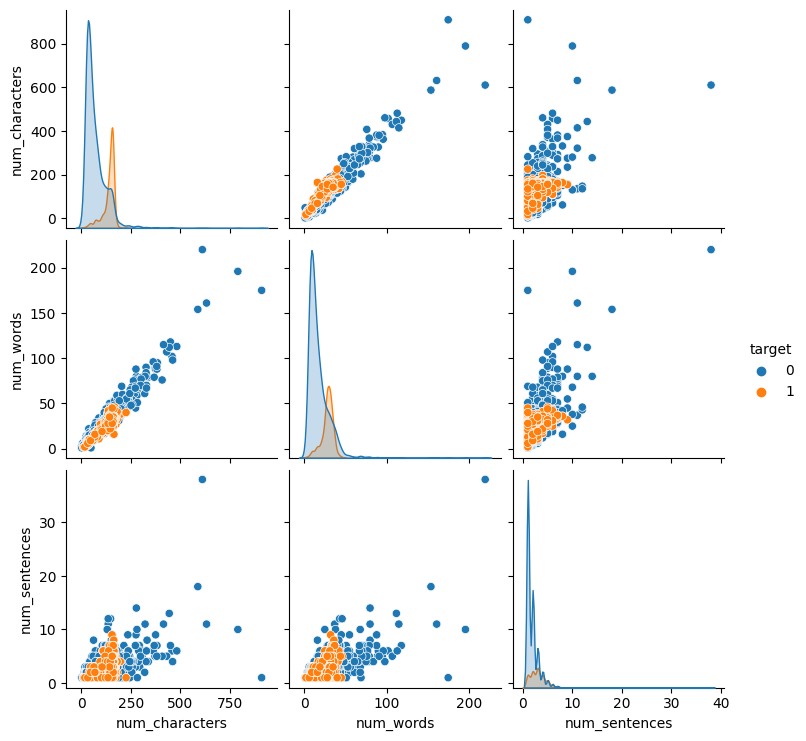

In [ ]:
sns.pairplot(df, hue = 'target')

In [ ]:
df.corr()

<ipython-input-48-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,target,num_characters,num_words,num_sentences
target,1.000000,0.468122,0.326786,0.317935
num_characters,0.468122,1.000000,0.960711,0.621341
num_words,0.326786,0.960711,1.000000,0.673360
num_sentences,0.317935,0.621341,0.673360,1.000000


<ipython-input-49-fe43fffaf13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<Axes: >

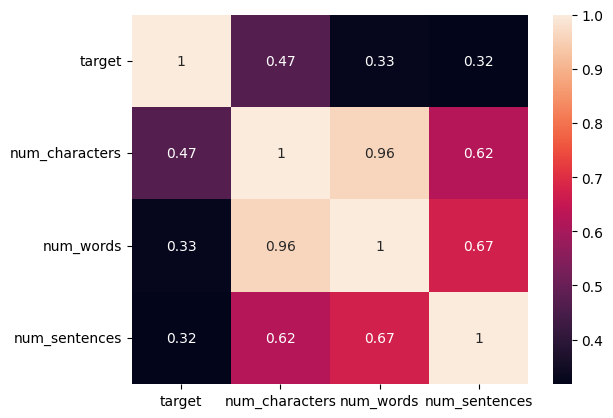

In [ ]:
sns.heatmap(df.corr(), annot = True)

## **Data Preprocessing**

Tokenisation

Removing stop words and punctuation

Stemming

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
ps.stem('loving')

'love'

In [ ]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

In [ ]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")


'gon na home soon want talk stuff anymor tonight k cri enough today'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size = 0.2, random_state = 1)

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
X_train_transformed = tfidf.fit_transform(X_train.apply(transform_text))

In [ ]:
# Applying SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)


In [ ]:
y_train.value_counts()

0    3624
1     938
Name: target, dtype: int64

In [ ]:
y_train_resampled.value_counts()

0    3624
1    3624
Name: target, dtype: int64

# **Model Building**




In [ ]:
svm_model = svm.SVC()

In [ ]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale', 'auto'],
    'degree': [2, 3]
}

In [ ]:
# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'gamma': [0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
# Preprocess and transform the test data
X_test_transformed = tfidf.transform(X_test.apply(transform_text))

In [ ]:
# Predict using the best model
y_pred = best_model.predict(X_test_transformed)


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9868536371603857
Precision: 0.9717741935483871
Recall: 0.9678714859437751
F1 Score: 0.9698189134808854
ROC AUC: 0.9800119761557441
Confusion Matrix:
[[885   7]
 [  8 241]]


In [ ]:

def predict_ham_or_spam(sentence):
    # Preprocess the input sentence using transform_text
    preprocessed_sentence = transform_text(sentence)

    # Transform the preprocessed sentence using the fitted tfidf vectorizer
    sentence_tfidf = tfidf.transform([preprocessed_sentence])

    # Predict using the pre-trained model
    prediction = best_model.predict(sentence_tfidf)

    # Determine the label based on the prediction
    label = "spam" if prediction[0] == 1 else "ham"

    return label


In [ ]:
# Test with your own sentences
sentence1 = "I love u so much"
sentence2 = "Congratulations! You've won a prize. Call now to claim."

In [ ]:
result1 = predict_ham_or_spam(sentence1)
result2 = predict_ham_or_spam(sentence2)

print(f"Sentence 1: {sentence1} => Prediction: {result1}")
print(f"Sentence 2: {sentence2} => Prediction: {result2}")

Sentence 1: I love u so much => Prediction: ham
Sentence 2: Congratulations! You've won a prize. Call now to claim. => Prediction: spam


In [ ]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(best_model,open('model.pkl','wb'))